In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import itertools

In [ ]:
# Load your data
df_loaded = pd.read_csv("/content/delhi_aqi.csv")

# Ensure the date column is properly formatted as datetime
df_loaded['From Date'] = pd.to_datetime(df_loaded['From Date'])
df_loaded.set_index('From Date', inplace=True)

# Quick check of the data
print(f"Data shape: {df_loaded.shape}")
print(df_loaded.head())

# Ensure index is datetime type
if not isinstance(df_loaded.index, pd.DatetimeIndex):
    print(f"Warning: Index is type '{type(df_loaded.index)}', attempting conversion.")
    try:
        df_loaded.index = pd.to_datetime(df_loaded.index, errors='coerce')
        df_loaded.dropna(subset=[df_loaded.index.name], inplace=True)  # Drop rows where index conversion failed
        print("Index successfully converted to DatetimeIndex.")
    except Exception as idx_err:
        print(f"Error: Could not convert index to DatetimeIndex: {idx_err}")
        exit()


Data shape: (4838, 12)
            PM2_5  PM10        NO2       SO2  CO_ug      Ozone      Temp  \
From Date                                                                  
2010-01-01    0.0   0.0  32.591083  5.999417    0.0  29.307250  7.822417   
2010-01-02    0.0   0.0  44.230333  6.785167    0.0  16.458833  5.964417   
2010-01-03    0.0   0.0  32.089833  5.332417    0.0  17.234667  5.968833   
2010-01-04    0.0   0.0  14.383588  3.837176    0.0  18.384656  6.878244   
2010-01-05    0.0   0.0  36.045903  3.765139    0.0  22.128750  8.070278   

                   RH        WS          BP         WD   RF  
From Date                                                    
2010-01-01  42.778417  0.188167  392.411500  44.862667  0.0  
2010-01-02  53.555833  0.259833  393.107667  21.817833  0.0  
2010-01-03  45.518500  0.396250  310.380583  27.094250  0.0  
2010-01-04  52.399847  0.930458  426.012824  47.768779  0.0  
2010-01-05  54.378472  1.009375  471.394236  36.517361  0.0  


In [ ]:
def calculate_aqi_pm25(pm25):
    # AQI calculation function for PM2.5
    breakpoints = [0, 12, 35.4, 55.4, 150.4, 250.4, 350.4, 500.4]
    index_values = [0, 50, 100, 150, 200, 300, 400, 500]

    try:
        pm25 = float(pm25)
    except (ValueError, TypeError):
        return np.nan

    if pd.isna(pm25):
        return np.nan

    if pm25 <= breakpoints[0]:
        return index_values[0]

    for i in range(len(breakpoints) - 1):
        if i == 0:
            if breakpoints[i] <= pm25 <= breakpoints[i + 1]:
                bp_low_idx, bp_high_idx = i, i + 1
                break
        else:
            if breakpoints[i] < pm25 <= breakpoints[i + 1]:
                bp_low_idx, bp_high_idx = i, i + 1
                break
    else:
        if pm25 > breakpoints[-1]:
            return index_values[-1]  # Cap at 500
        else:
            return np.nan

    aqi_low, aqi_high = index_values[bp_low_idx], index_values[bp_high_idx]
    breakpoint_low, breakpoint_high = breakpoints[bp_low_idx], breakpoints[bp_high_idx]

    if breakpoint_high == breakpoint_low:
        return aqi_low

    aqi = ((aqi_high - aqi_low) / (breakpoint_high - breakpoint_low)) * (pm25 - breakpoint_low) + aqi_low

    # Ensure AQI doesn't exceed max due to float issues if extrapolating
    return min(aqi, index_values[-1]) if pm25 > breakpoints[-1] else aqi

In [ ]:
# Process the data for time series analysis
df_processed = df_loaded[['PM2_5']].copy()
df_processed['AQI (PM2.5)'] = df_processed['PM2_5'].apply(calculate_aqi_pm25)

# Handle missing values
df_processed.fillna(method='ffill', inplace=True)
df_processed.dropna(inplace=True)
df_processed = df_processed.sort_index()

# Filter to more recent data (2018 onwards)
df_daily_final = df_processed.loc['2018-01-01':].copy()

print(f"Daily data points (2018+): {len(df_daily_final)}")
if len(df_daily_final) == 0:
    raise ValueError("No daily data found starting from 2018-01-01.")
print(df_daily_final.head())

# Set a proper frequency for the time series
if df_daily_final.index.freq is None:
    df_daily_final = df_daily_final.asfreq('D')
    # Fill any gaps created by setting frequency
    df_daily_final.fillna(method='ffill', inplace=True)

print(f"Time series frequency: {df_daily_final.index.freq}")

Daily data points (2018+): 1916
                 PM2_5  AQI (PM2.5)
From Date                          
2018-01-01  263.389213   312.989213
2018-01-02  255.326528   304.926528
2018-01-03  197.158032   246.758032
2018-01-04  226.977569   276.577569
2018-01-05  221.421412   271.021412
Time series frequency: <Day>


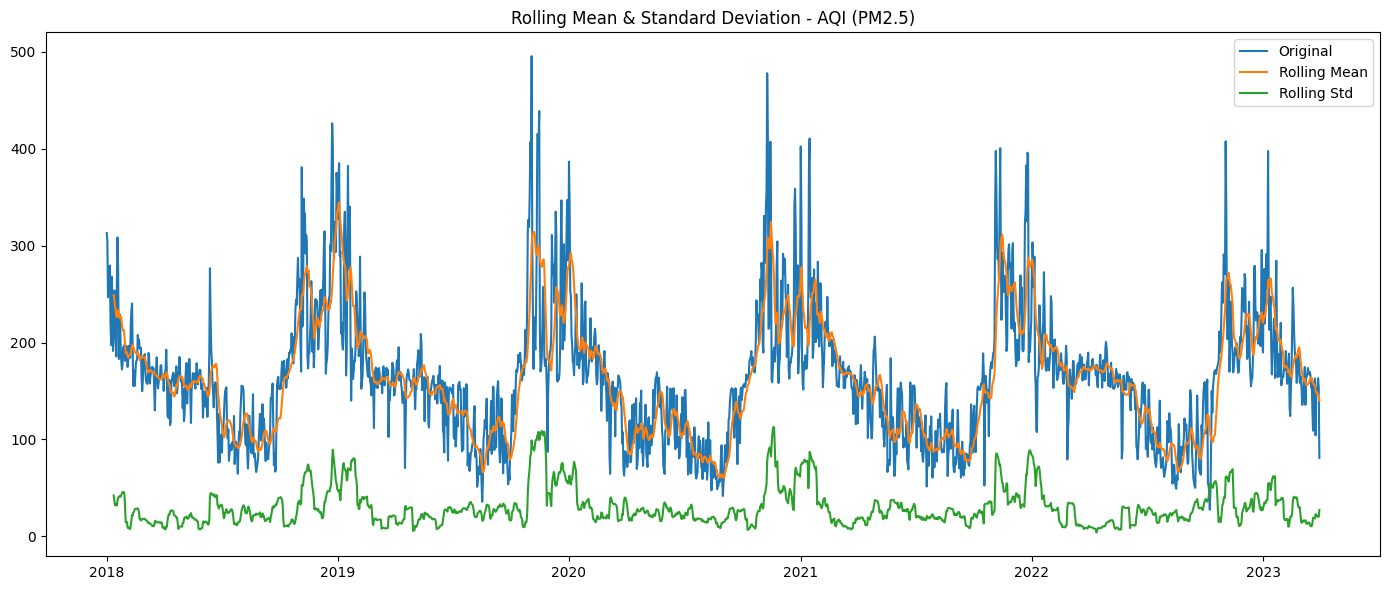

Results of Dickey-Fuller Test:
Test Statistic                   -4.347028
p-value                           0.000368
#Lags Used                       11.000000
Number of Observations Used    1904.000000
Critical Value (1%)              -3.433789
Critical Value (5%)              -2.863059
Critical Value (10%)             -2.567579
dtype: float64
Conclusion: The series is stationary


In [ ]:
# Check stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title=''):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation - {title}')
    plt.tight_layout()
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion: The series is stationary")
    else:
        print("Conclusion: The series is not stationary")

# Test stationarity on the AQI series
test_stationarity(df_daily_final['AQI (PM2.5)'], title='AQI (PM2.5)')

In [ ]:
# Select the AQI column for decomposition
ts = df_daily_final['AQI (PM2.5)']

# CRITICAL FIX: Set the correct period parameter
# For daily data with annual seasonality, use period=365
# This is the most important fix for your flat residual issue
period = 365  # Specify annual seasonality for daily data

len(ts)

1916

# Directly Applying ARMA on series

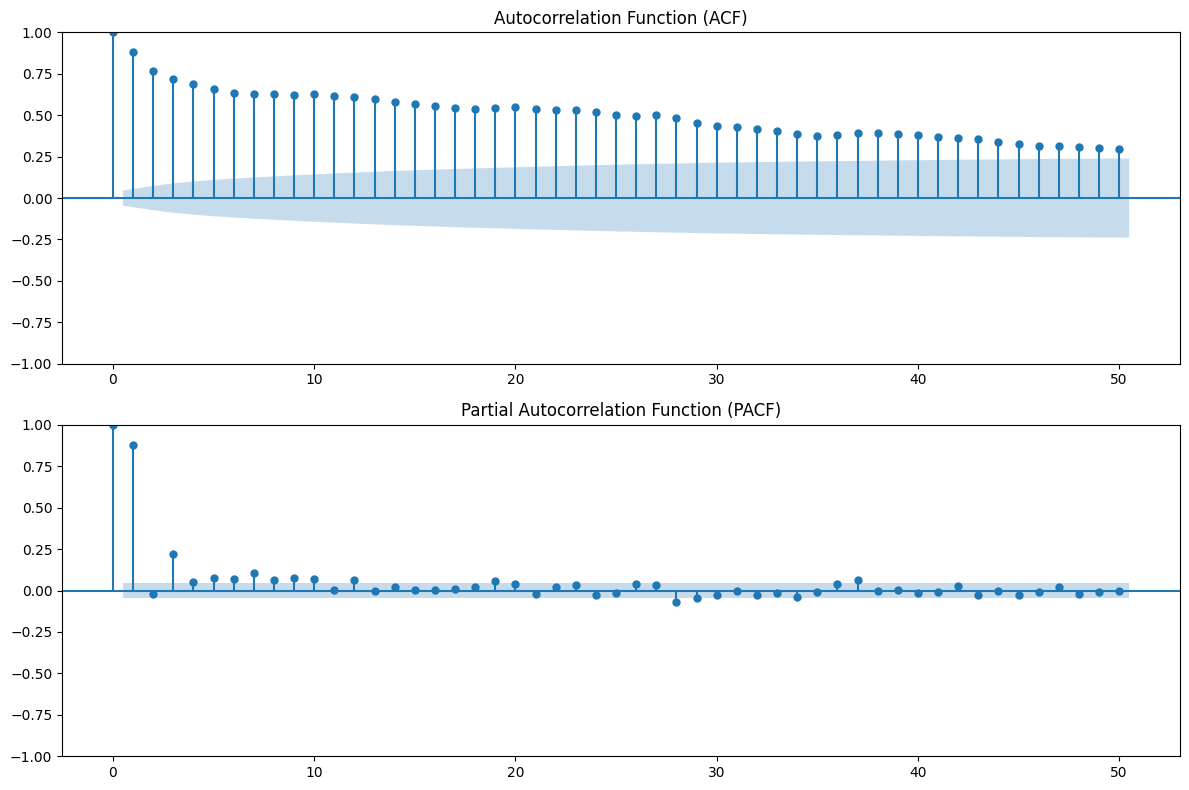

In [ ]:
# Plot ACF and PACF to determine AR and MA orders
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Function to plot ACF and PACF
def plot_acf_pacf(series, lags=40, figsize=(12, 8)):
    fig, axes = plt.subplots(2, 1, figsize=figsize)

    # Plot ACF
    plot_acf(series, ax=axes[0], lags=lags)
    axes[0].set_title('Autocorrelation Function (ACF)')

    # Plot PACF
    plot_pacf(series, ax=axes[1], lags=lags)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for the AQI series
plot_acf_pacf(ts.loc[:'2022-12-31'], lags=50)

Best ARMA Parameters (based on AIC): ARMA(3, 5)
Best AIC: 17701.103165647943


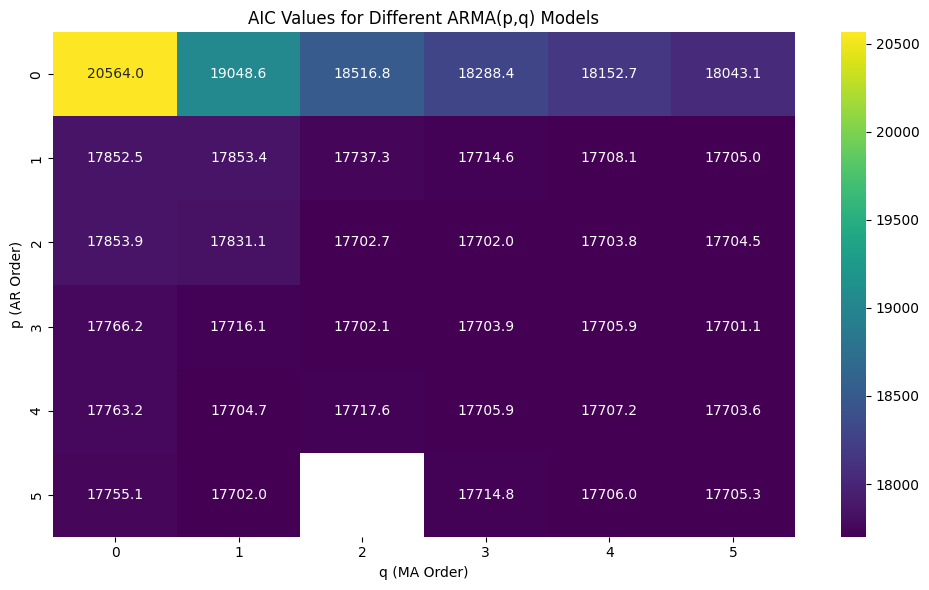

In [ ]:
# Grid search for optimal ARMA parameters
import itertools
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

def grid_search_arma(series, p_range, q_range):
    best_aic = float('inf')
    best_bic = float('inf')
    best_params = None
    best_model = None

    results = []

    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(series, order=(p, 0, q))  # d=0 for ARMA model
            model_fit = model.fit()

            results.append({
                'p': p,
                'q': q,
                'aic': model_fit.aic,
                'bic': model_fit.bic
            })

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (p, q)
                best_model = model_fit
        except:
            continue

    results_df = pd.DataFrame(results)

    print(f"Best ARMA Parameters (based on AIC): ARMA({best_params[0]}, {best_params[1]})")
    print(f"Best AIC: {best_aic}")

    return best_model, results_df

# Define ranges for p and q
p_range = range(0, 6)  # AR order
q_range = range(0, 6)  # MA order

# Perform grid search
best_model, results_df = grid_search_arma(ts.loc[:'2022-12-31'], p_range, q_range)

# Visualize the AIC results
plt.figure(figsize=(10, 6))
pivot_table = results_df.pivot(index='p', columns='q', values='aic')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='viridis')
plt.title('AIC Values for Different ARMA(p,q) Models')
plt.xlabel('q (MA Order)')
plt.ylabel('p (AR Order)')
plt.tight_layout()
plt.show()

In [ ]:
train = df_daily_final.loc[:'2022-12-31']['AQI (PM2.5)']
test = df_daily_final.loc['2023-01-01':]['AQI (PM2.5)']

In [ ]:
model = ARIMA(train, order=(3, 0, 5))
fitted_model = model.fit()
forecast_result = fitted_model.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure forecast index aligns with test
forecast.index = test.index

# Compute RMSE manually by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE on 2023 test data: {rmse:.2f}")

RMSE on 2023 test data: 40.90


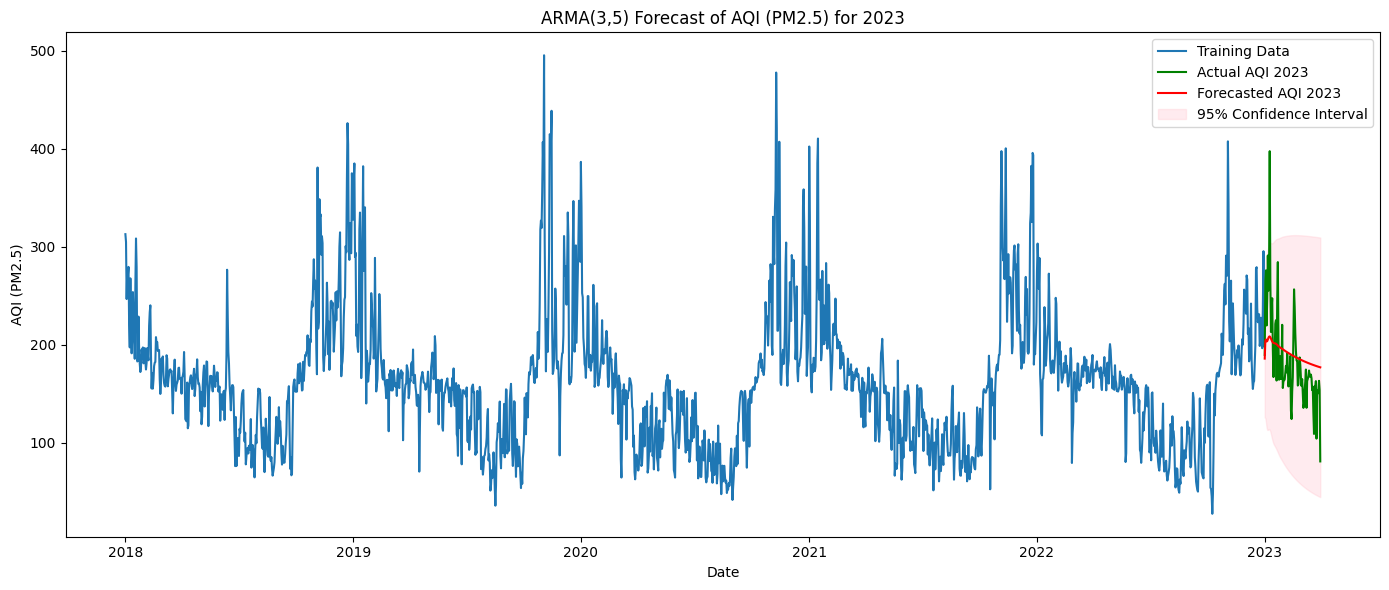

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual AQI 2023', color='green')
plt.plot(forecast, label='Forecasted AQI 2023', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('ARMA(3,5) Forecast of AQI (PM2.5) for 2023')
plt.xlabel('Date')
plt.ylabel('AQI (PM2.5)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1],
    'Actual': test
})
forecast_df.head()

,Forecast,Lower CI (95%),Upper CI (95%),Actual
2023-01-01,185.952020,125.825144,246.078896,189.758405
2023-01-02,204.148409,125.255254,283.041564,264.970937
2023-01-03,205.497102,121.020310,289.973894,276.021000
2023-01-04,203.494166,115.543906,291.444426,219.746562
2023-01-05,203.779797,113.262511,294.297083,246.976677


# Decomposing the series and then applying ARMA

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(df_daily_final['AQI (PM2.5)'], period=365, robust=True)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

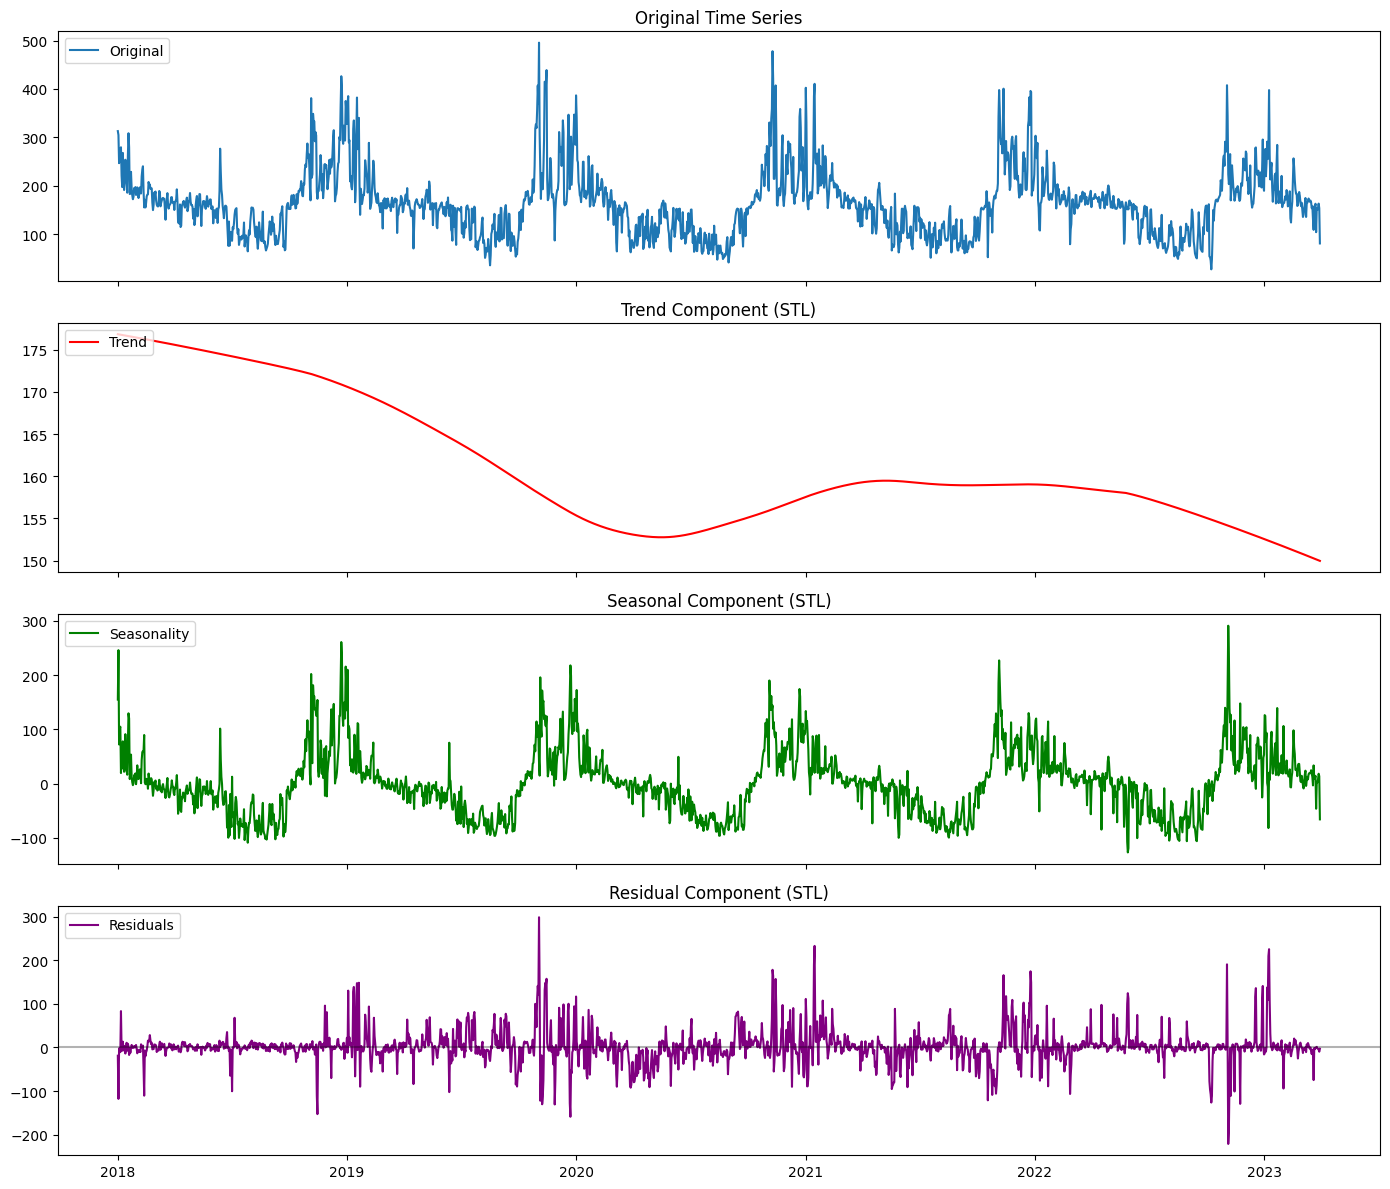

In [ ]:
# STL Decomposition (Seasonal-Trend decomposition using LOESS)
# This is often more robust than the traditional seasonal_decompose
stl = STL(
    ts,
    period=period,  # Same annual period
    seasonal=13,    # Controls smoothness of seasonal component
    trend=None,     # Automatically determine trend window
    robust=True     # Use robust estimation (less sensitive to outliers)
)
result = stl.fit()

# Plot the STL decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Original data
axes[0].plot(ts, label='Original')
axes[0].legend(loc='upper left')
axes[0].set_title('Original Time Series')

# Trend component
axes[1].plot(result.trend, label='Trend', color='red')
axes[1].legend(loc='upper left')
axes[1].set_title('Trend Component (STL)')

# Seasonal component
axes[2].plot(result.seasonal, label='Seasonality', color='green')
axes[2].legend(loc='upper left')
axes[2].set_title('Seasonal Component (STL)')

# Residual component
axes[3].plot(result.resid, label='Residuals', color='purple')
axes[3].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[3].legend(loc='upper left')
axes[3].set_title('Residual Component (STL)')

plt.tight_layout()
plt.show()

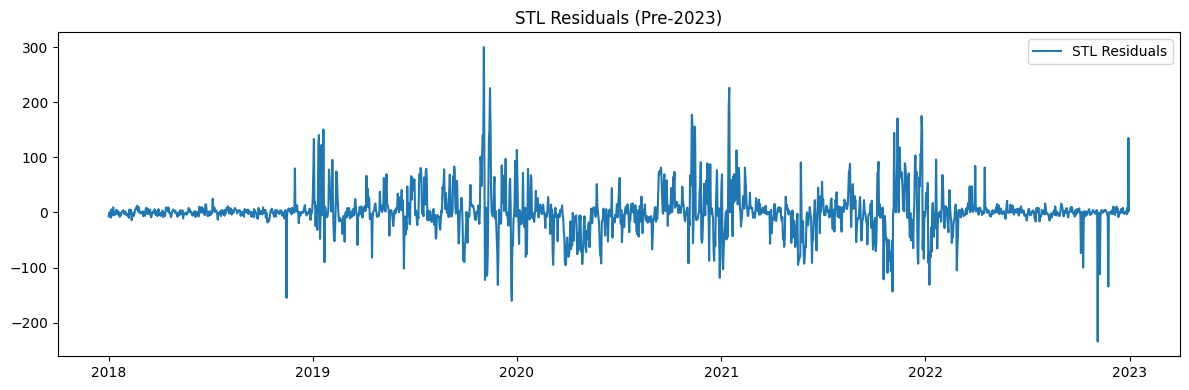

ADF Test Statistic: -10.6398
p-value: 0.0000
 Residuals are stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# STL residuals (from earlier STL decomposition)
residual_train = residual[:'2022-12-31']

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residual_train, label='STL Residuals')
plt.title('STL Residuals (Pre-2023)')
plt.legend()
plt.tight_layout()
plt.show()

# ADF test
adf_result = adfuller(residual_train.dropna())
print(f"ADF Test Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] <= 0.05:
    print(" Residuals are stationary.")
    stationary_residual = residual_train
else:
    print(" Residuals are NOT stationary. Differencing applied.")
    stationary_residual = residual_train.diff().dropna()

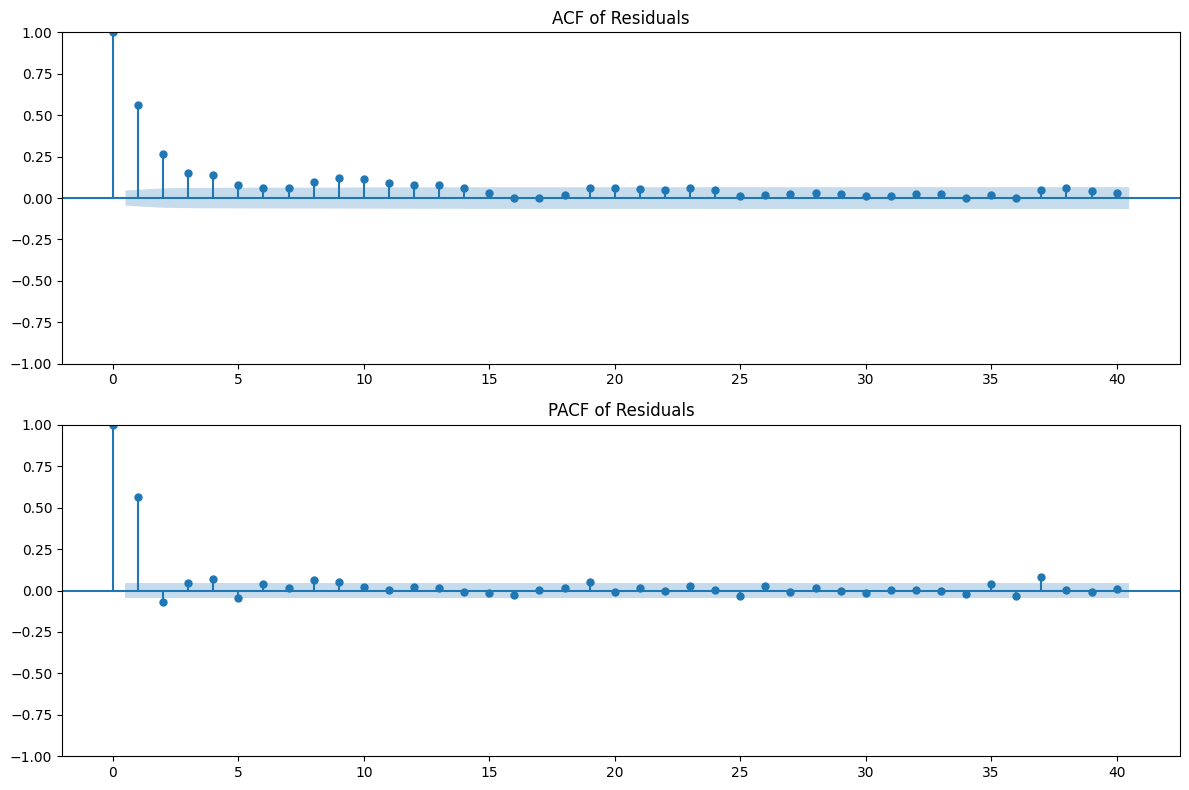

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(stationary_residual, ax=plt.gca(), lags=40)
plt.title("ACF of Residuals")

plt.subplot(2, 1, 2)
plot_pacf(stationary_residual, ax=plt.gca(), lags=40)
plt.title("PACF of Residuals")

plt.tight_layout()
plt.show()


Starting grid search for ARIMA(p, 0, q) orders...
p range: [0, 1, 2, 3], q range: [0, 1, 2, 3]
------------------------------
Grid Search Complete.
Best Parameters (based on AIC): ARIMA(3, 0, 3)
Best AIC: 17704.24
------------------------------

Forecasting residuals using best model: ARIMA(3, 0, 3)...

RMSE with STL + Best ARMA(3, 0, 3) residual forecast: 24.19
Generating plot...


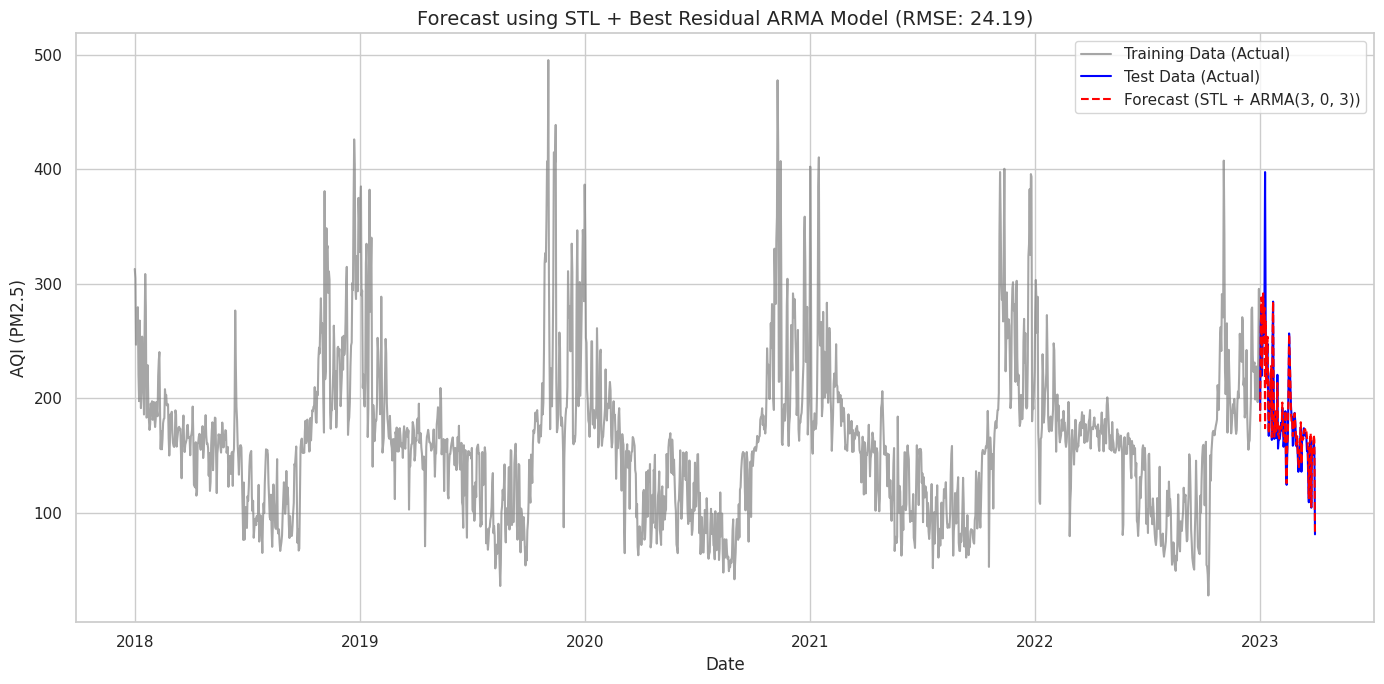

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def grid_search_arma(series, p_range, q_range, d=0):
    """Performs grid search for ARIMA(p, d, q) and returns best model based on AIC."""
    best_aic = float('inf')
    best_params = None
    best_model_fit = None
    results = []

    # Ensure the series has no NaNs which can cause issues
    series = series.dropna()
    if series.empty:
        print("Warning: Series is empty after dropping NaNs. Cannot perform grid search.")
        return None, None, pd.DataFrame(results)

    print(f"\nStarting grid search for ARIMA(p, {d}, q) orders...")
    print(f"p range: {list(p_range)}, q range: {list(q_range)}")

    for p, q in itertools.product(p_range, q_range):
        # Skip ARMA(0,0) model as it's usually trivial (white noise)
        if p == 0 and q == 0:
            continue
        order = (p, d, q)
        try:
            model = ARIMA(series, order=order)
            model_fit = model.fit()

            current_aic = model_fit.aic
            results.append({'p': p, 'd': d, 'q': q, 'aic': current_aic})

            if current_aic < best_aic:
                best_aic = current_aic
                best_params = {'p': p, 'd': d, 'q': q}
                best_model_fit = model_fit # Store the fitted model object

        except Exception as e:
            # print(f"Could not fit ARIMA{order}: {e}") # Optional: uncomment for detailed errors
            results.append({'p': p, 'd': d, 'q': q, 'aic': np.nan}) # Log failure
            continue

    results_df = pd.DataFrame(results)

    if best_params:
        print("-" * 30)
        print(f"Grid Search Complete.")
        print(f"Best Parameters (based on AIC): ARIMA({best_params['p']}, {best_params['d']}, {best_params['q']})")
        print(f"Best AIC: {best_aic:.2f}")
        print("-" * 30)
    else:
        print("-" * 30)
        print("Grid Search Warning: Could not find a suitable model.")
        print("-" * 30)


    return best_model_fit, best_params, results_df

residual_train = residual[:'2022-12-31'].dropna() # Ensure no leading/trailing NaNs
residual_test = residual['2023-01-01':]
n_forecast = len(residual_test)

# Define parameter ranges for the grid search
# Adjust ranges as needed, smaller ranges run faster
p_param_range = range(0, 4) # Example range for AR order (p)
q_param_range = range(0, 4) # Example range for MA order (q)

# Perform grid search on the training residuals to find the best ARMA(p,q) order (d=0)
best_residual_model_fitted, best_arma_params, _ = grid_search_arma(
    residual_train,
    p_range=p_param_range,
    q_range=q_param_range,
    d=0  # d=0 because we want ARMA on potentially stationary residuals
)

# Check if the grid search was successful
if not best_residual_model_fitted or not best_arma_params:
    print("Error: Grid search failed to find the best model. Exiting.")
    # Optionally, fall back to a default order or raise an error
    # best_arma_params = {'p': 2, 'd': 0, 'q': 0} # Example fallback
    # model = ARIMA(residual_train, order=(best_arma_params['p'], best_arma_params['d'], best_arma_params['q']))
    # best_residual_model_fitted = model.fit()
    # if not best_residual_model_fitted:
    raise ValueError("Could not fit a fallback model after grid search failed.")

# Use the best model found by grid search to forecast residuals
print(f"\nForecasting residuals using best model: ARIMA{tuple(best_arma_params.values())}...")
forecast_obj = best_residual_model_fitted.get_forecast(steps=n_forecast)
resid_forecast = forecast_obj.predicted_mean
# Optional: Get confidence intervals if needed later
# resid_conf_int = forecast_obj.conf_int(alpha=0.05)

# Reconstruct full forecast
# Make sure trend/seasonal components cover the forecast period
trend_forecast = trend.reindex(residual_test.index) # Use reindex for safety
seasonal_forecast = seasonal.reindex(residual_test.index) # Use reindex for safety

# Ensure residual forecast index aligns with test period before adding
resid_forecast.index = residual_test.index

final_forecast = trend_forecast + seasonal_forecast + resid_forecast

# Align final forecast index with actual data index for evaluation
actual = ts['2023-01-01':]
final_forecast = final_forecast.reindex(actual.index) # Align index

# Evaluate (handle potential NaNs from reindexing/missing data)
valid_idx = actual.notna() & final_forecast.notna()
actual_eval = actual[valid_idx]
final_forecast_eval = final_forecast[valid_idx]

if len(actual_eval) > 0:
    rmse = np.sqrt(mean_squared_error(actual_eval, final_forecast_eval))
    print(f"\nRMSE with STL + Best ARMA{tuple(best_arma_params.values())} residual forecast: {rmse:.2f}")
    rmse_str = f"{rmse:.2f}"
else:
    print("\nWarning: No overlapping valid data for RMSE calculation.")
    rmse_str = "N/A"


# Plot
print("Generating plot...")
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid") # Optional: apply seaborn style

plt.plot(ts[:'2022-12-31'], label="Training Data (Actual)", color='grey', alpha=0.7)
plt.plot(actual, label="Test Data (Actual)", color='blue', linewidth=1.5)
plt.plot(final_forecast, label=f"Forecast (STL + ARMA{tuple(best_arma_params.values())})", color='red', linestyle='--')

# Optional: Add confidence intervals to plot if calculated
# plt.fill_between(final_forecast.index, final_lower_ci, final_upper_ci, color='red', alpha=0.2, label='95% CI')

plt.title(f"Forecast using STL + Best Residual ARMA Model (RMSE: {rmse_str})", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel(ts.name if ts.name else "Value", fontsize=12) # Use series name if available
plt.legend()
plt.tight_layout()
plt.show()

sns.reset_defaults() # Optional: reset seaborn style

# Revenue of AIR Purifiers

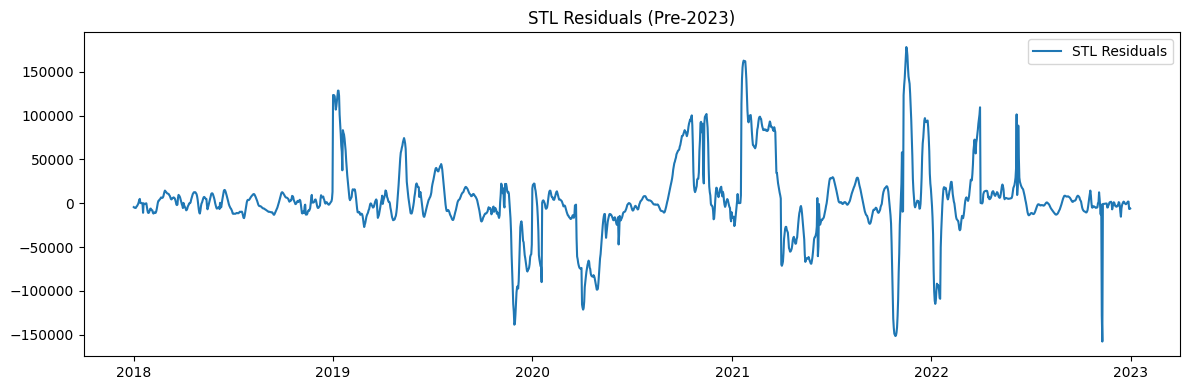

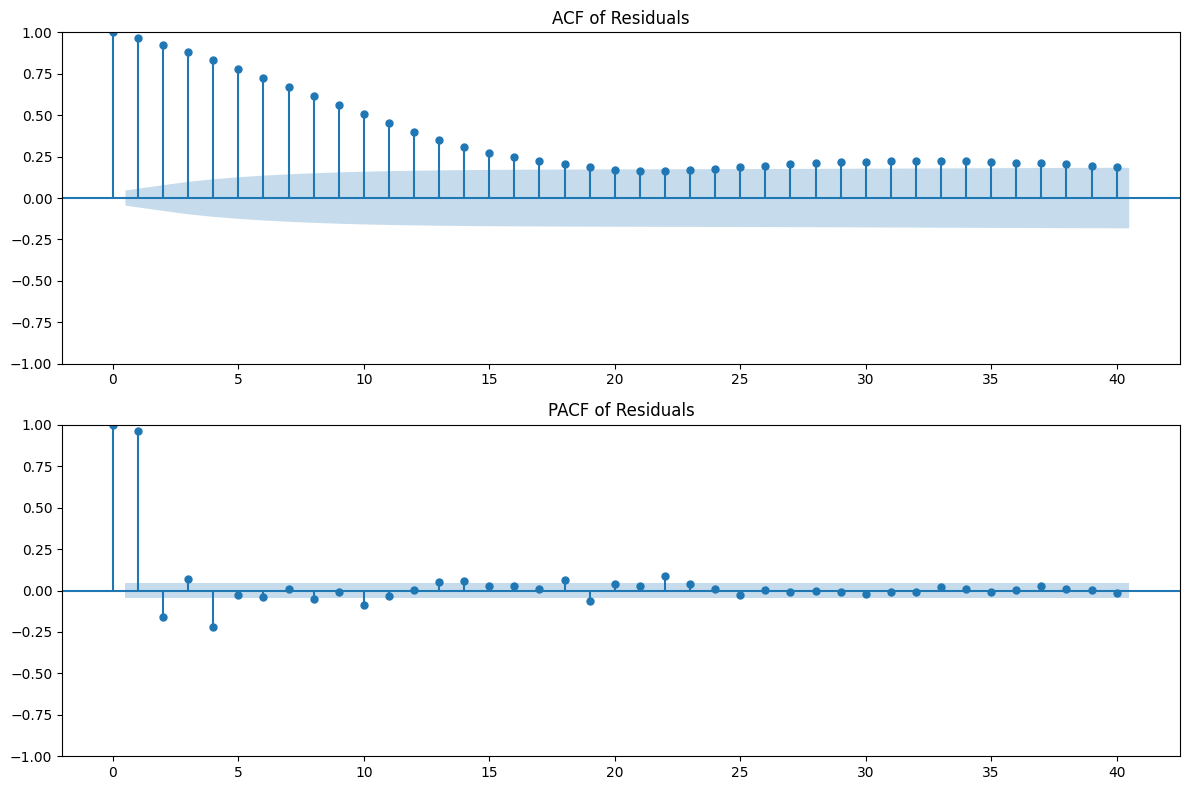

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load and preprocess revenue data
df = pd.read_csv('/content/delhi_revenue_data_2018_2023.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.loc['2018-01-01':]
df = df.asfreq('D')
df['Revenue'] = df['Revenue'].replace(0, np.nan).interpolate(method='time').fillna(method='ffill')

# 2. STL decomposition (annual seasonality)
ts = df['Revenue']
stl = STL(ts, period=365, robust=True)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# 3. Use only residuals up to end of 2022 for ARMA model selection
residual_train = residual[:'2022-12-31']

# 4. Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residual_train, label='STL Residuals')
plt.title('STL Residuals (Pre-2023)')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Plot ACF and PACF for the residuals
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(residual_train.dropna(), ax=plt.gca(), lags=40)
plt.title("ACF of Residuals")
plt.subplot(2, 1, 2)
plot_pacf(residual_train.dropna(), ax=plt.gca(), lags=40)
plt.title("PACF of Residuals")
plt.tight_layout()
plt.show()

Best ARMA Parameters (AIC): ARMA(4, 5)
Best AIC: 38955.14258873749


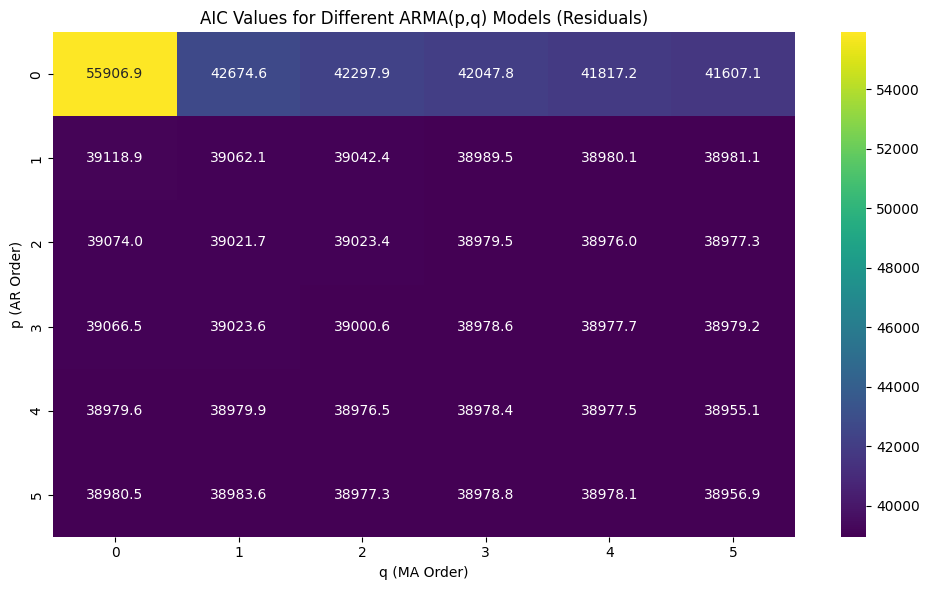

In [ ]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 3. Split residuals into train/test
residual_train = residual.loc[:'2022-12-31']
residual_test = residual.loc['2023-01-01':]

# 4. Grid search for ARMA(p, q) on residuals
def grid_search_arma(series, p_range, q_range):
    best_aic = float('inf')
    best_params = None
    best_model = None
    results = []
    for p, q in itertools.product(p_range, q_range):
        try:
            model = ARIMA(series, order=(p, 0, q))
            model_fit = model.fit()
            results.append({'p': p, 'q': q, 'aic': model_fit.aic})
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (p, q)
                best_model = model_fit
        except:
            continue
    results_df = pd.DataFrame(results)
    print(f"Best ARMA Parameters (AIC): ARMA{best_params}")
    print(f"Best AIC: {best_aic}")
    return best_model, results_df

p_range = range(0, 6)
q_range = range(0, 6)
best_model, results_df = grid_search_arma(residual_train.dropna(), p_range, q_range)

# 5. Visualize AIC results
plt.figure(figsize=(10, 6))
pivot_table = results_df.pivot(index='p', columns='q', values='aic')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='viridis')
plt.title('AIC Values for Different ARMA(p,q) Models (Residuals)')
plt.xlabel('q (MA Order)')
plt.ylabel('p (AR Order)')
plt.tight_layout()
plt.show()

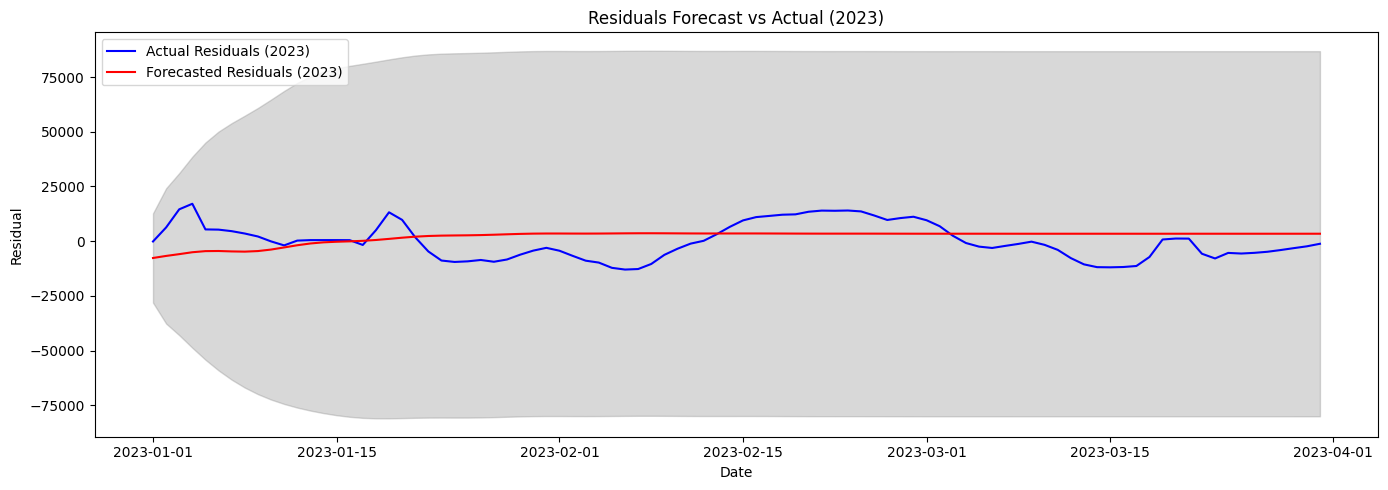

In [ ]:
# 6. Forecast residuals for 2023 using best ARMA model
n_forecast = len(residual_test)
forecast_res = best_model.get_forecast(steps=n_forecast)
resid_pred = forecast_res.predicted_mean
resid_ci = forecast_res.conf_int(alpha=0.05)

# Align indices
resid_pred.index = residual_test.index
resid_ci.index = residual_test.index

# 7. Plot residual forecast vs actual residuals
plt.figure(figsize=(14, 5))
plt.plot(residual_test, label='Actual Residuals (2023)', color='blue')
plt.plot(resid_pred, label='Forecasted Residuals (2023)', color='red')
plt.fill_between(resid_ci.index, resid_ci.iloc[:, 0], resid_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title('Residuals Forecast vs Actual (2023)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.tight_layout()
plt.show()

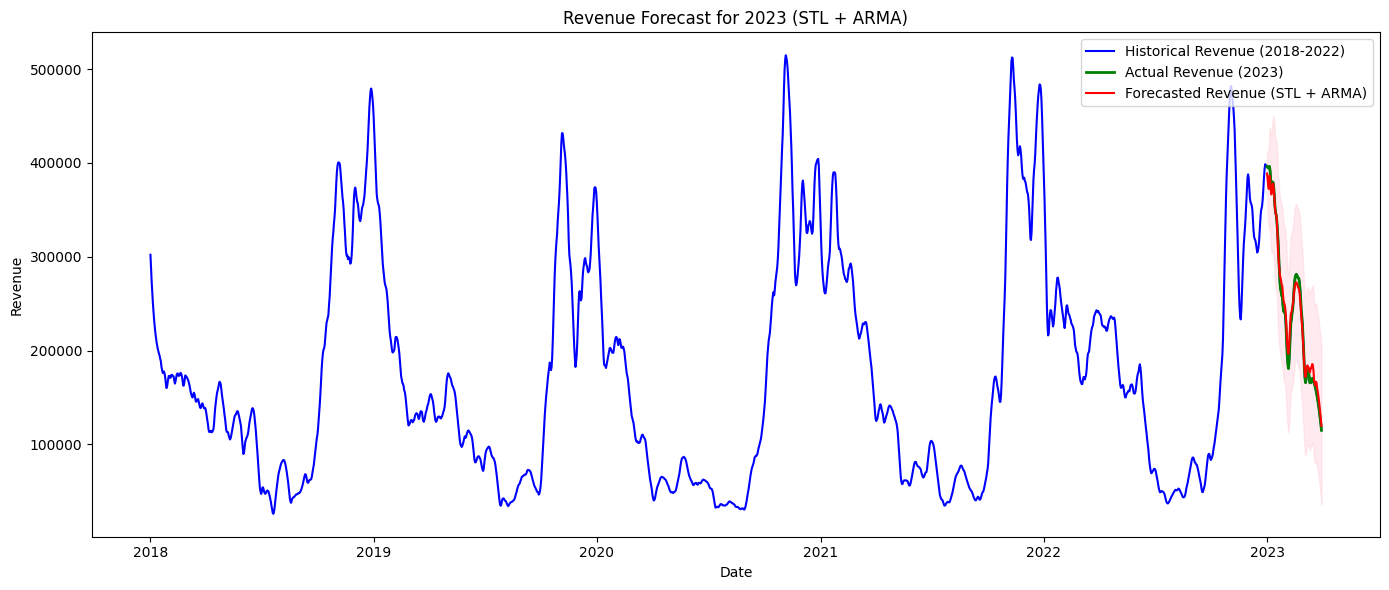

In [ ]:
# 8. Reconstruct full forecast
trend_forecast = trend['2023-01-01':]
seasonal_forecast = seasonal['2023-01-01':]
final_forecast = trend_forecast + seasonal_forecast + resid_pred
lower = trend_forecast + seasonal_forecast + resid_ci.iloc[:, 0]
upper = trend_forecast + seasonal_forecast + resid_ci.iloc[:, 1]

# 9. Plot the final forecast with confidence intervals
actual = df['Revenue']['2023-01-01':]
plt.figure(figsize=(14, 6))
plt.plot(df['Revenue'], label='Historical Revenue (2018-2022)', color='blue')
plt.plot(actual, label='Actual Revenue (2023)', color='green', linewidth=2)
plt.plot(final_forecast, label='Forecasted Revenue (STL + ARMA)', color='red')
plt.fill_between(final_forecast.index, lower, upper, color='pink', alpha=0.3)
plt.title('Revenue Forecast for 2023 (STL + ARMA)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

Comparing the trend

Calculating monthly averages...
Generating plot...
Plot saved as 'delhi_seasonal_revenue_aqi_pattern_simple_legend.png'


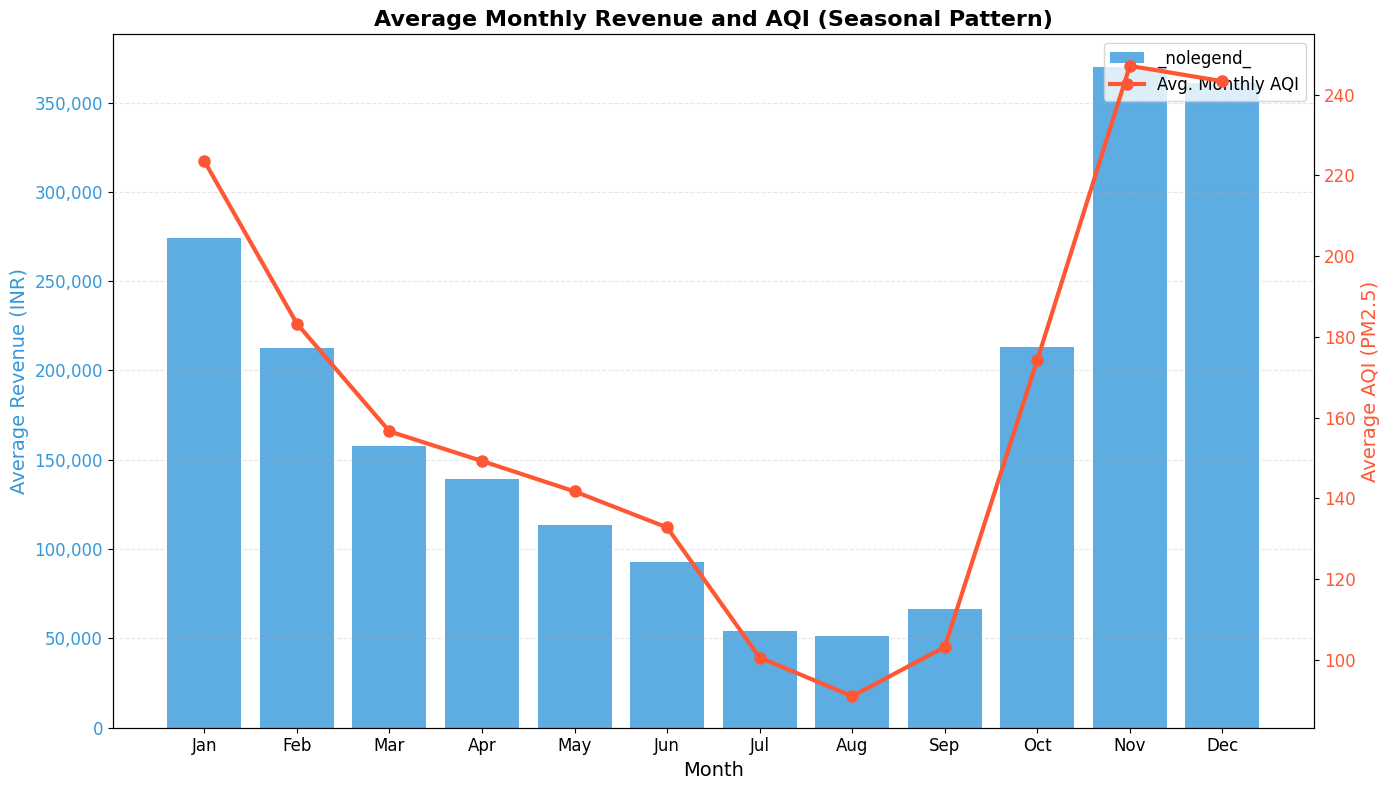

In [ ]:
from matplotlib.ticker import FuncFormatter
# 1. Calculate Monthly Averages
print("Calculating monthly averages...")
monthly_avg_revenue = ts.groupby(ts.index.month).mean()
monthly_avg_aqi = df_daily_final.groupby(df_daily_final.index.month)['AQI (PM2.5)'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# 2. Create the Plot
print("Generating plot...")
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Revenue bars - Assign the returned BarContainer to 'bars'
bars = ax1.bar(months, monthly_avg_revenue.values, color='#3498DB', alpha=0.8, label='Avg. Monthly Revenue') # Label is important here
ax1.set_title('Average Monthly Revenue and AQI (Seasonal Pattern)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Average Revenue (INR)', fontsize=14, color='#3498DB')
ax1.tick_params(axis='y', labelcolor='#3498DB', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

# Create secondary axis
ax2 = ax1.twinx()

# Plot AQI line - Assign the list containing the Line2D object to 'line_plot'
line_plot = ax2.plot(months, monthly_avg_aqi.values, color='#FF5733', linewidth=3, marker='o', markersize=8, label='Avg. Monthly AQI') # Label is important here
ax2.set_ylabel('Average AQI (PM2.5)', fontsize=14, color='#FF5733')
ax2.tick_params(axis='y', labelcolor='#FF5733', labelsize=12)

# --- Corrected Legend Handling ---
# Get the handles:
# For bars, we need one representative patch (the first one is fine).
# For the line, plot returns a list, so we take the first element.
handle_revenue = bars[0]
handle_aqi = line_plot[0]

# Create the legend using these specific handles and their labels
ax1.legend(handles=[handle_revenue, handle_aqi], loc='upper right', fontsize=12)
# --- End of Corrected Legend Handling ---

# Add grid lines
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
# Optional grid for the second axis if desired
# ax2.grid(True, alpha=0.3, axis='y', linestyle=':')

# Improve layout and save
plt.tight_layout()
plt.savefig('delhi_seasonal_revenue_aqi_pattern_simple_legend.png', dpi=300)
print("Plot saved as 'delhi_seasonal_revenue_aqi_pattern_simple_legend.png'")
plt.show()